<a href="https://colab.research.google.com/github/asatbayev/Coursera_Capstone/blob/main/Segmenting_and_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmenting and Clustering Neighborhoods in Toronto**

In [1]:
#Importing the required libraries
!pip install bs4
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd #this module helps us to work with dataframes

## **1. Downloading and scraping the contents of a web page into the dataframe**

Retreiving the URL of webpage with Toronto postal codes and creating a Beautiful soup object:

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" #Download the contents of the web page
data = requests.get(url).text #Use "get" to download the contents of the webpage in text format and store in a variable called "data"
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data'

Scraping the contents of a web page:

In [15]:
table_contents=[] #create a list
table=soup.find('table') #finding the table and table data
for row in table.findAll('td'):
    cell = {} #create a dictionary having 3 keys PostalCode, Borough and Neighborhood
    if row.span.text=='Not assigned': #ignore cells with a Borough that is "Not assigned" 
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] #take first 3 chars as a PostalCode
        cell['Borough'] = (row.span.text).split('(')[0] #getting Borough information
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ') #getting Neighborhood information
        table_contents.append(cell) #append the scrapped cell to the "table_contents" list
print(table_contents) #checking resulting list

[{'PostalCode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'}, {'PostalCode': 'M4A', 'Borough': 'North York', 'Neighborhood': 'Victoria Village'}, {'PostalCode': 'M5A', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Regent Park, Harbourfront'}, {'PostalCode': 'M6A', 'Borough': 'North York', 'Neighborhood': 'Lawrence Manor, Lawrence Heights'}, {'PostalCode': 'M7A', 'Borough': "Queen's Park", 'Neighborhood': 'Ontario Provincial Government'}, {'PostalCode': 'M9A', 'Borough': 'Etobicoke', 'Neighborhood': 'Islington Avenue'}, {'PostalCode': 'M1B', 'Borough': 'Scarborough', 'Neighborhood': 'Malvern, Rouge'}, {'PostalCode': 'M3B', 'Borough': 'North York', 'Neighborhood': 'Don Mills North'}, {'PostalCode': 'M4B', 'Borough': 'East York', 'Neighborhood': 'Parkview Hill, Woodbine Gardens'}, {'PostalCode': 'M5B', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Garden District, Ryerson'}, {'PostalCode': 'M6B', 'Borough': 'North York', 'Neighborhood': 'Glencairn'}, {'PostalCode': 'M9

Creating dataframe based on "table_contents" and replacing "Not assigned" Neighborhoods to its Boroughs

In [17]:
df=pd.DataFrame(table_contents) #creating dataframe based on "table_contents" list
#replacing the names of some Boroughs
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


df_postcode = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df_postcode.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [22]:
df_postcode.shape #checking the shape of dataframe


(103, 3)

## **2. Getting the latitude and the longitude coordinates of each neighborhood**

In [21]:
coords_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code') #upload Geospatial_Coordinates.csv in dataframe
coords_df = coords_df.rename(columns={'Postal Code':'PostalCode'}) #rename Postal Code column to be the same as in df_postcode for further join
toronto_data = df_postcode.join(coords_df, on='PostalCode') #join two dataframes
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## **3. Exploring and clustering the neighborhoods in Toronto**

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [23]:
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import numpy as np

### **3.1. Download and Explore Dataset**

**Use geopy library to get the latitude and longitude values of Toronto.**

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent tor_explorer, as shown below.

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**Create a map of Toronto with neighborhoods superimposed on top.**

In [77]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

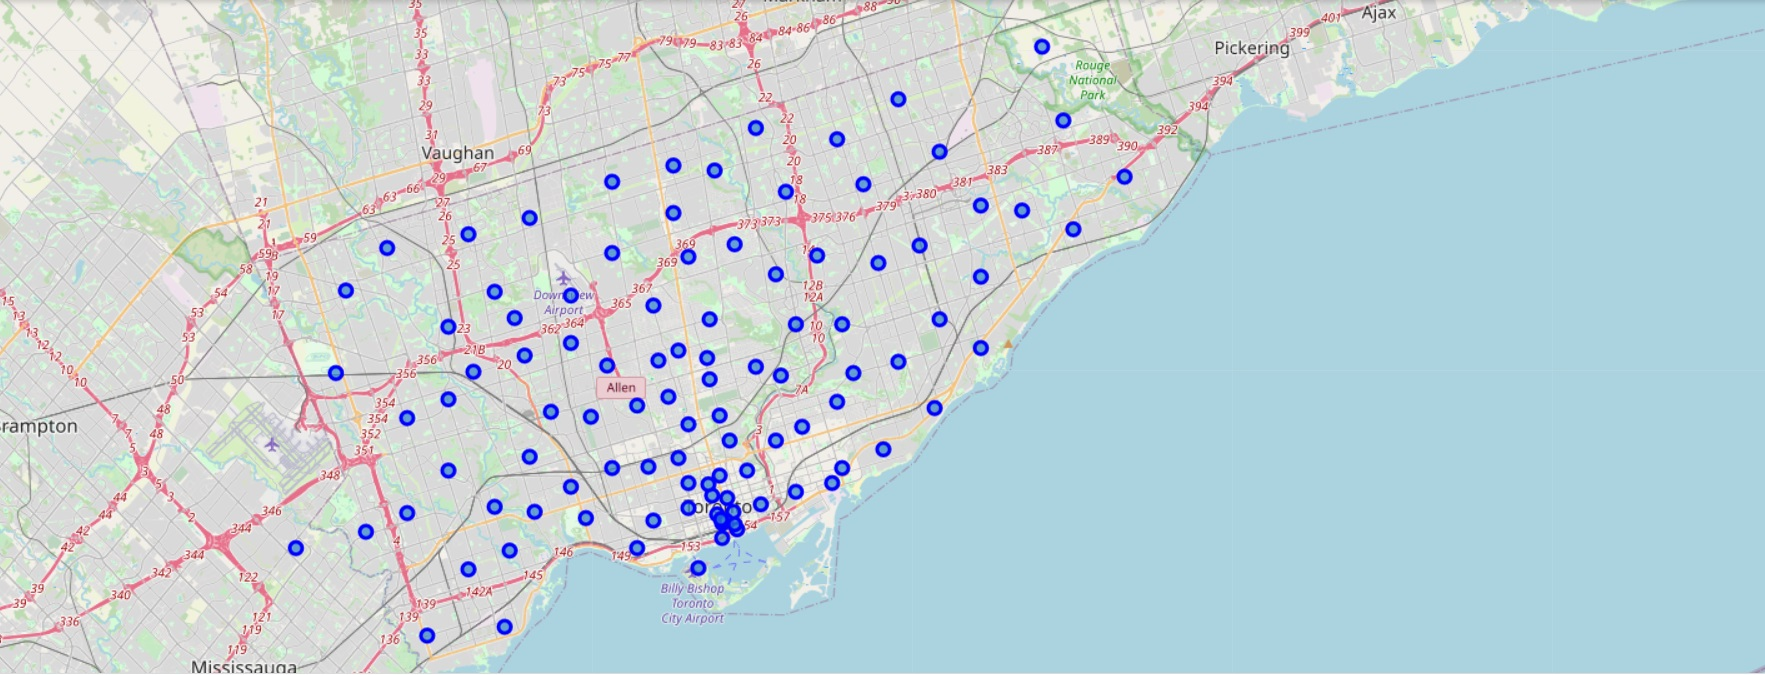

Let's simplify the above map and segment and cluster only the neighborhoods in Boroughs containing 'Toronto' in its name. So let's slice the original dataframe and create a new dataframe of the selected Boroughs.

In [29]:
toronto_boroughs = toronto_data.loc[toronto_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_boroughs.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
4,M4M,East Toronto,Studio District,43.659526,-79.340923


In [30]:
toronto_boroughs.shape

(39, 5)

Let's visualize selected Boroughs.

In [78]:
# create map of Toronto using latitude and longitude values
map_boroughs = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_boroughs['Latitude'], toronto_boroughs['Longitude'], toronto_boroughs['Borough'], toronto_boroughs['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boroughs)

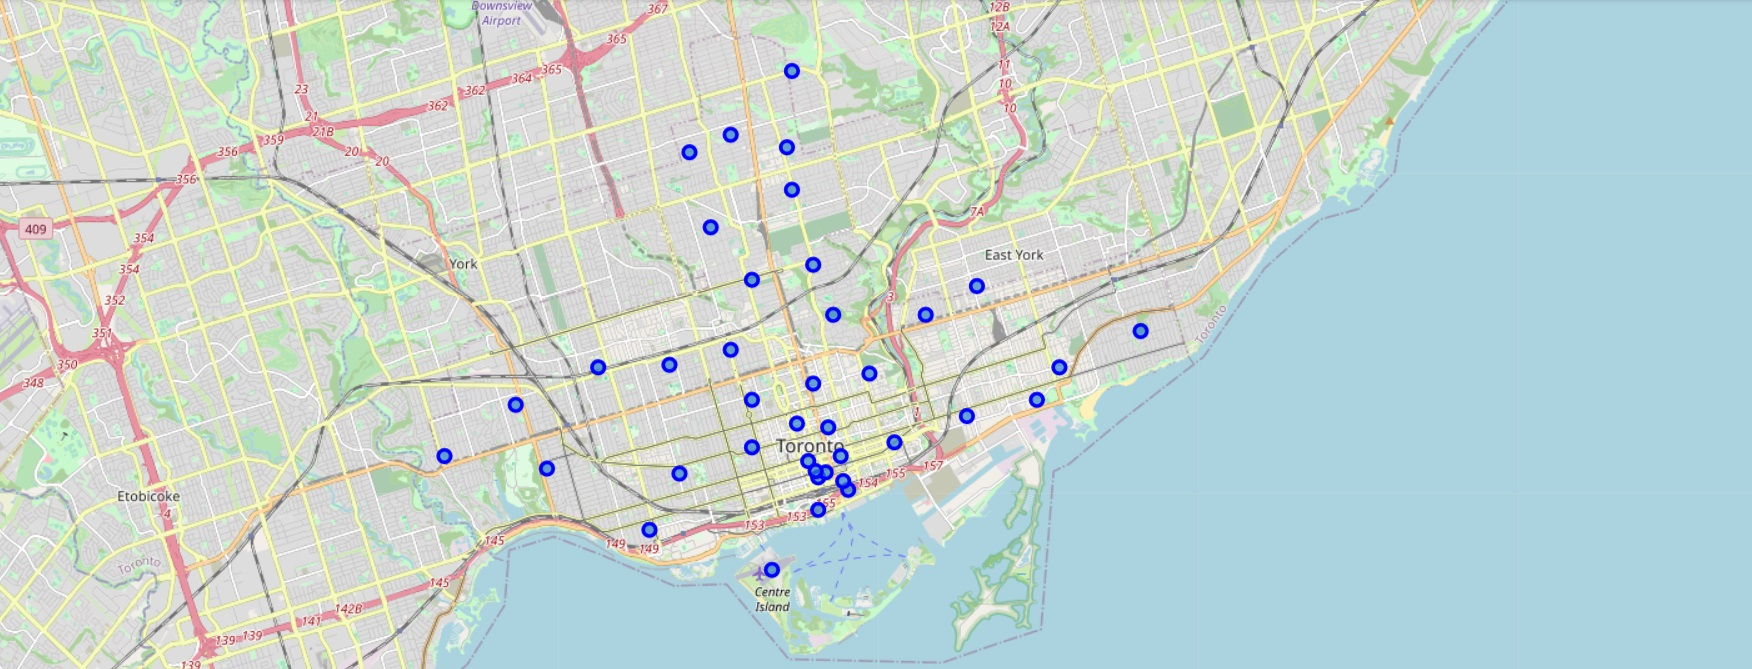

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

**Define Foursquare Credentials and Version**

In [83]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

CLIENT_ID = 'NDA4SUYL5ES3TEUQEOWGAU5I0CICW3DQULVOASJEOCZ1ITOQ' # your Foursquare ID
CLIENT_SECRET = '3VDVJ2H3MUO15M2PMHT5XFP3PP1X1CJ2DXSLRZAU4PTNBBDM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

**Let's explore the first neighborhood in our dataframe.**

Get the neighborhood's name.

In [34]:
toronto_boroughs.loc[0, 'Neighborhood']

'The Beaches'

Get the neighborhood's latitude and longitude values.

In [35]:
neighborhood_latitude = toronto_boroughs.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_boroughs.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_boroughs.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


**Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.**


First, let's create the GET request URL. Name your URL url.

In [37]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude,
    radius, 
    LIMIT)

Send the GET request

In [38]:
results = requests.get(url).json()

All the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [40]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


And how many venues were returned by Foursquare?

In [41]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


### **3.2. Explore Neighborhoods in Boroughs containing 'Toronto' in its name**

**Let's create a function to repeat the same process to all the neighborhoods in Boroughs containing 'Toronto' in its name**

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_borough_venues.**

In [44]:
toronto_borough_venues = getNearbyVenues(names=toronto_boroughs['Neighborhood'],
                                   latitudes=toronto_boroughs['Latitude'],
                                   longitudes=toronto_boroughs['Longitude']
                                  )

The Beaches
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Enclave of M5E
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction 

Let's check the size of the resulting dataframe

In [45]:
print(toronto_borough_venues.shape)
toronto_borough_venues.head()

(1591, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,Aldwych Park,43.684901,-79.341091,Park


Let's check how many venues were returned for each neighborhood

In [46]:
toronto_borough_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,15,15,15,15,15,15
Church and Wellesley,81,81,81,81,81,81
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36
Davisville North,8,8,8,8,8,8


Let's find out how many unique categories can be curated from all the returned venues

In [47]:
print('There are {} uniques categories.'.format(len(toronto_borough_venues['Venue Category'].unique())))

There are 231 uniques categories.


### **3.3. Analyze Each Neighborhood**

In [51]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_borough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_borough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [52]:
toronto_onehot.shape

(1591, 231)

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [53]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,...,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.052632,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.000000,0.017544,0.0000,0.000000,0.0000,0.000000,0.017544,0.000000,0.000000,0.000000,...,0.000000,0.017544,0.000000,0.000000,0.035088,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.00,0.00,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.00000,0.00,0.000000,0.017544,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.017544,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.080000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.0625,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000
3,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.0000,0.014706,0.0000,0.000000,0.000000,0.000000,0.029412,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.00,0.000000,0.00000,0.00,0.014706,0.014706,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.014706,0.000000,0.000000,0.014706
4,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

Let's confirm the new size

In [54]:
toronto_grouped.shape

(39, 231)

**Let's print each neighborhood along with the top 5 most common venues**

In [55]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.05
1        Bakery  0.05
2  Cocktail Bar  0.05
3      Beer Bar  0.04
4      Pharmacy  0.04


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.12
1  Performing Arts Venue  0.08
2            Coffee Shop  0.08
3         Breakfast Spot  0.08
4                 Bakery  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0  Airport Service  0.19
1   Airport Lounge  0.12
2         Boutique  0.06
3  Harbor / Marina  0.06
4    Boat or Ferry  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.16
1                 Café  0.06
2       Sandwich Place  0.06
3   Italian Restaurant  0.06
4  Japanese Restaurant  0.03


----Christie----
           venue  freq
0  Grocery Store  0.27
1           Café  0.20
2           Park  0.13
3    Coffee Shop  0.07
4  

**Let's put that into a pandas dataframe**

First, let's write a function to sort the venues in descending order.

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Bakery,Coffee Shop,Cocktail Bar,Pharmacy,Cheese Shop,Beer Bar,Seafood Restaurant,Restaurant,Pub,Farmers Market
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Performing Arts Venue,Breakfast Spot,Grocery Store,Restaurant,Bar,Intersection,Italian Restaurant,Burrito Place
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Boat or Ferry,Harbor / Marina,Boutique,Rental Car Location,Bar,Coffee Shop,Sculpture Garden,Airport Gate
3,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Restaurant,Japanese Restaurant,Bubble Tea Shop,Burger Joint,Miscellaneous Shop
4,Christie,Grocery Store,Café,Park,Baby Store,Candy Store,Italian Restaurant,Restaurant,Coffee Shop,Nightclub,Dumpling Restaurant


### **3.4. Cluster Neighborhoods**

Run k-means to cluster the neighborhood into 5 clusters.

In [58]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_boroughs

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,4,Park,Convenience Store,Metro Station,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Grocery Store,Fruit & Vegetable Store,Pub,Pizza Place,Lounge
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Pizza Place,Sandwich Place,Fish & Chips Shop,Steakhouse,Fast Food Restaurant,Ice Cream Shop,Sushi Restaurant,Burrito Place,Intersection,Pet Store
4,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Music Store,Convenience Store,Cheese Shop,Pet Store


Finally, let's visualize the resulting clusters

In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

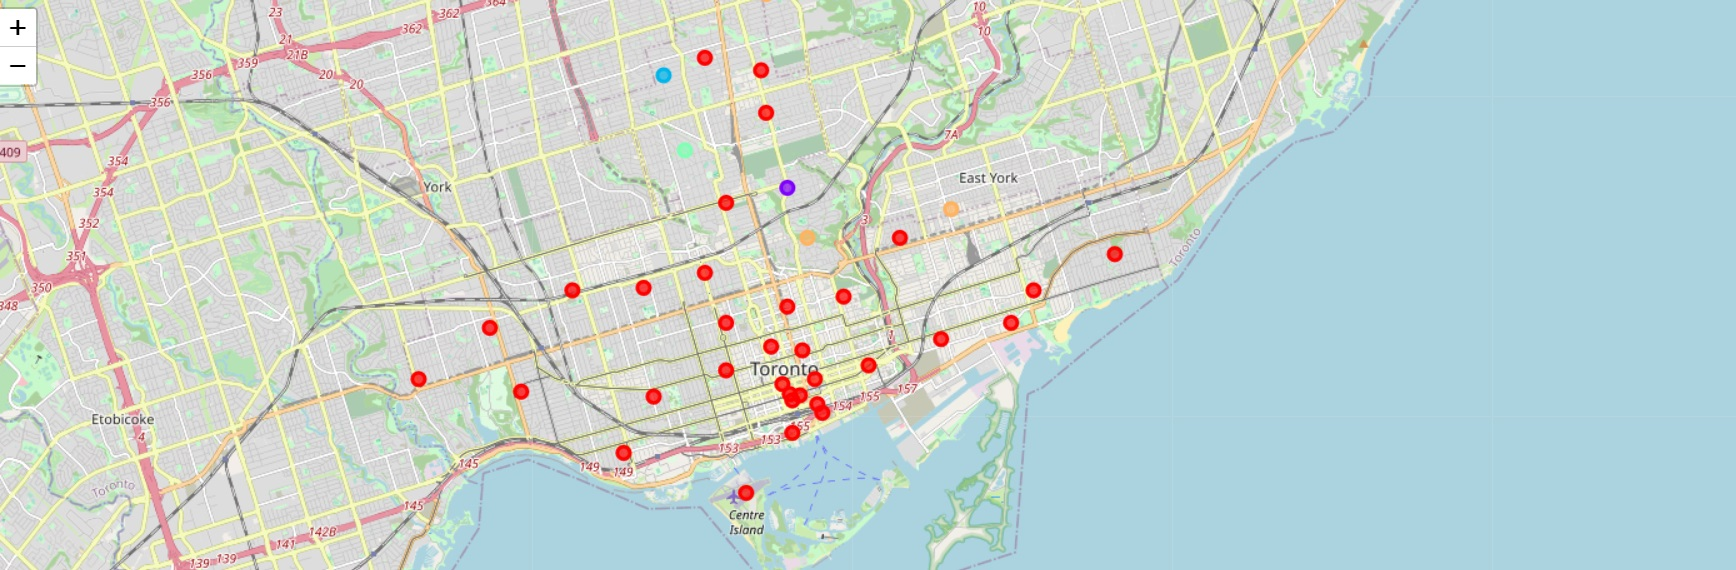

**3.5. Examine Clusters**

**Cluster 1 - Coffee Shops, Restaurants**

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,0,Trail,Health Food Store,Pub,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
2,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Grocery Store,Fruit & Vegetable Store,Pub,Pizza Place,Lounge
3,"India Bazaar, The Beaches West",0,Pizza Place,Sandwich Place,Fish & Chips Shop,Steakhouse,Fast Food Restaurant,Ice Cream Shop,Sushi Restaurant,Burrito Place,Intersection,Pet Store
4,Studio District,0,Coffee Shop,Bakery,Gastropub,Brewery,Café,American Restaurant,Music Store,Convenience Store,Cheese Shop,Pet Store
6,Davisville North,0,Sandwich Place,Park,Hotel,Food & Drink Shop,Breakfast Spot,Department Store,Gym / Fitness Center,Gym,Eastern European Restaurant,Dumpling Restaurant
7,North Toronto West,0,Clothing Store,Coffee Shop,Sporting Goods Shop,Gym / Fitness Center,Fast Food Restaurant,Diner,Mexican Restaurant,Cosmetics Shop,Park,Chinese Restaurant
8,Davisville,0,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Italian Restaurant,Café,Gym,Thai Restaurant,Sushi Restaurant,Indian Restaurant
10,"Summerhill West, Rathnelly, South Hill, Forest...",0,Coffee Shop,Sushi Restaurant,American Restaurant,Supermarket,Bank,Pub,Fried Chicken Joint,Pizza Place,Bagel Shop,Restaurant
12,"St. James Town, Cabbagetown",0,Coffee Shop,Restaurant,Pub,Café,Italian Restaurant,Bakery,Pizza Place,Market,Chinese Restaurant,Butcher
13,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant


**Cluster 2 - Playground**

In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Moore Park, Summerhill East",1,Playground,Wine Bar,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


**Cluster 3 - Home Service**

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Roselawn,2,Home Service,Garden,Wine Bar,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


**Cluster 4 - Bus Line**

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Forest Hill North & West,3,Bus Line,Jewelry Store,Trail,Sushi Restaurant,Wine Bar,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


**Cluster 5 - Parks**

In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,The Danforth East,4,Park,Convenience Store,Metro Station,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
5,Lawrence Park,4,Swim School,Park,Bus Line,Wine Bar,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
11,Rosedale,4,Park,Trail,Playground,Wine Bar,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
